In [ ]:
!unzip "./data.zip"

In [3]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import pandas as pd
from aux import ImagesMRIDataset, split_for_cross_validation, get_training_testing_data, plot_data, get_data_distribution, split_traing_data

def create_data(train_transforms, test_transforms, batch_size, train=None, validation=None, test=None):
    data = {
        "train": None,
        "validation": None,
        "test": None,
    }
    if not train == None:    
        data["train"] = DataLoader(ImagesMRIDataset(train, transformations=train_transforms), batch_size=batch_size, shuffle=True, drop_last=True)
    if not validation == None:
        data["validation"] = DataLoader(ImagesMRIDataset(validation, transformations=test_transforms), batch_size=batch_size, shuffle=True)
    if not test == None:
        data["test"] =  DataLoader(ImagesMRIDataset(test, transformations=test_transforms), batch_size=batch_size, shuffle=True)
    return data 


/home/alf/anul4/InvSup/tema2/venv/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.22). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [11]:
SIZE = (50, 50)
train_transform = A.Compose([
    A.Resize(height=SIZE[0], width=SIZE[1]),  
    A.RandomGamma(gamma_limit=(80, 120), p=1.0),
    A.AdvancedBlur(blur_limit=(3, 5), p=0.5),  
    A.CLAHE(clip_limit=5.0, tile_grid_size=(8, 8), p=1.0),
    A.HorizontalFlip(p=0.5), 
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8), 
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

test_transformations = A.Compose([
    A.Resize(height=SIZE[0], width=SIZE[1]),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

def compute_train_transformations(image):
    image = train_transform(image=image)["image"]
    return np.array(image.transpose((2, 0, 1)), dtype=np.float32)
    
def compute_test_transformation(image):
    image = test_transformations(image=image)["image"]
    return np.array(image.transpose((2, 0, 1)), dtype=np.float32)


In [7]:
def training_loop(model, criterion, optimizer, dataloader, batch_size):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  current_training_loss = 0
  all_train_labels, all_train_preds = [], []
  model.train()
  for idx, (images, labels) in enumerate(dataloader):
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    output = output.to(device)
    loss = criterion(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    current_training_loss += loss.item()
    all_train_preds.extend(output.argmax(dim=1).cpu().numpy())
    all_train_labels.extend(labels.cpu().numpy())
  return current_training_loss / dataloader.__len__() / batch_size, all_train_preds, all_train_labels


def validation_loop(model, criterion, dataloader, batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_val_labels, all_val_preds = [], [],
    current_validation_loss = 0
    model.eval()
    with torch.no_grad():
      for idx, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        output = output.to(device)
        loss = criterion(output, labels)
        current_validation_loss += loss.item()
        all_val_labels.extend(labels.cpu().numpy())
        all_val_preds.extend(output.argmax(dim=1).cpu().numpy())
    return current_validation_loss / dataloader.__len__() / batch_size,  all_val_preds, all_val_labels

def train_model(model, epochs, data, criterion, optimizer, lr_scheduler, batch_size):
  training_loss = np.zeros(shape=(epochs,))
  validation_loss = np.zeros(shape=(epochs,))
  training_accuracy = np.zeros(shape=(epochs,))
  validation_accuracy = np.zeros(shape=(epochs,))
  for i in range(epochs):
    Tloss, train_pred, train_labels = training_loop(model, criterion, optimizer, data["train"], batch_size)
    Vloss, all_val_preds, all_val_labels = validation_loop(model, criterion, data["validation"], batch_size)
    lr_scheduler.step(Vloss)
    time.sleep(2)
    training_loss[i] = Tloss
    validation_loss[i] = Vloss
    training_accuracy[i] = accuracy_score(train_pred, train_labels)
    validation_accuracy[i] = accuracy_score(all_val_labels, all_val_preds)
    if (np.argmax(validation_accuracy) == i):
      print(f"best model found at {i}")
      # torch.save(model.state_dict(), "./best_model.pth")
    print(f"{i} is ready")
    if (i == epochs -1):
      print("termina aici")
      # torch.save(model.state_dict(), "./model.pth")
  return training_loss, validation_loss, training_accuracy, validation_accuracy

def test_model(model, dataloader, criterion, batch_size):
    _, preds, labels = validation_loop(model, criterion, dataloader, batch_size)
    precision = precision_score(preds, labels, average='macro') 
    recall = recall_score(preds, labels, average='macro')
    f1 = f1_score(preds, labels, average='macro')
    acc = accuracy_score(preds, labels)
    return precision, recall, f1, acc, confusion_matrix(preds, labels)


In [8]:
EPOCHS = 1
BATCH_SIZE = 10
WIDTH = 8
FACTOR = 4
LR = 1e-4
DECAY = 1e-4
PATIENCE = 2

def compute_weights(data):
    distribution = get_data_distribution(data)
    total_samples = sum(distribution)
    weights = np.zeros(shape=(len(distribution),))
    for i in range(len(distribution)):
        weights[i] = total_samples / distribution[i]    
    return weights


def get_parameters(model, weights = None):
  criterion = torch.nn.NLLLoss(reduction="sum", weight=weights)
  optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=DECAY)
  lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, threshold=1e-4, 
                                   patience=PATIENCE)
  return criterion, optimizer, lr_scheduler


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.width1 = WIDTH
        self.conv1 = nn.Conv2d(3, self.width1, kernel_size=(3, 3))
        self.bn1 = nn.BatchNorm2d(self.width1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.width2 = self.width1 * FACTOR
        self.conv2 = nn.Conv2d(self.width1, self.width2, kernel_size=(3, 3))
        self.bn2 = nn.BatchNorm2d(self.width2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.width3 = self.width2 * FACTOR
        self.conv3 = nn.Conv2d(self.width2, self.width3, kernel_size=(5, 5))
        self.bn3 = nn.BatchNorm2d(self.width3)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.width4 = self.width3 * FACTOR
        self.conv4 = nn.Conv2d(self.width3, self.width4, kernel_size=(3, 3))
        self.bn4 = nn.BatchNorm2d(self.width4)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classification_layer = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(self.width4, self.width3),
            nn.Dropout(p=0.3),
            nn.Linear(self.width3, self.width2),
            nn.Dropout(p=0.3),
            nn.Linear(self.width2, 4),
            nn.LogSoftmax(dim=1),
        )
        
    def forward(self, x : torch.tensor):
        x = self.maxpool1(self.relu(self.bn1(self.conv1(x))))
        x = self.maxpool2(self.relu(self.bn2(self.conv2(x))))
        x = self.maxpool3(self.relu(self.bn3(self.conv3(x))))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.avgpool(x)
        return self.classification_layer(x)


In [15]:
def save_plot(list1, list2, label1, label2, path, title):
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=range(1, len(list1) + 1), y=list1, label=label1, marker='o')
    sns.lineplot(x=range(1, len(list2) + 1), y=list2, label=label2, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(path, format="png")

def save_matrix(matrix, path):
    cm_display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = [0, 1, 2, 3])
    cm_display.plot()
    plt.tight_layout()
    plt.savefig(path, format='png')
    plt.close()

def create_plots_paths(current : int, task_id : int, helper_path = None):
    if helper_path == None:
        return {
            "loss": f"./images/task{task_id}/loss_model{current}.png",
            "accuracy": f"./images/task{task_id}/accuracy_model{current}.png",
            "matrix": f"./images/task{task_id}/confusion_matrix{current}.png"
        }
    return {
            "loss": f"./images/task{task_id}/{helper_path}/loss_model{current}.png",
            "accuracy": f"./images/task{task_id}/{helper_path}/accuracy_model{current}.png",
            "matrix": f"./images/task{task_id}/{helper_path}/confusion_matrix{current}.png"
    }
    
def add_info(info_data, precision, acc, recall, f1):
    info_data["precision"].append(precision)
    info_data["accuracy"].append(acc)
    info_data["recall"].append(recall)
    info_data["f1Score"].append(f1)
    return info_data


def create_cross_validation_data(data_chunks, test_data, current : int, train_tranform, test_tranform):
    training_data = []
    for idx, chunk in enumerate(data_chunks):
        if (idx == current):
            continue
        training_data += chunk
    return create_data(train_tranform, test_tranform, BATCH_SIZE,
                        training_data, data_chunks[current], test_data)
    

def cross_validation_training_one_model(data, paths, current : int, criterion, optimizer, lr_scheduler):
    model = Net()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    training_loss, validation_loss, training_accuracy, validation_accuracy = train_model(model, EPOCHS,
        data, criterion, optimizer, lr_scheduler, BATCH_SIZE)
    save_plot(training_loss, validation_loss, "Train Loss", "Validation Loss", 
              paths["loss"], f"Loss model{current}")
    save_plot(training_accuracy, validation_accuracy, "Train Accuracy", "Validation Accuracy", 
          paths["accuracy"], f"Accuracy model{current}")
    return model 

In [ ]:
model = Net()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
    
criterion, optimizer, lr_scheduler = get_parameters(model)
training_info, test_info = get_training_testing_data(True)
training_info, validation_info = split_traing_data(training_info, 0.2)
data = create_data(compute_train_transformations, compute_test_transformation, BATCH_SIZE, training_info, validation_info, test_info)
training_loss, validation_loss, training_accuracy, validation_accuracy = train_model(model, EPOCHS,
    data, criterion, optimizer, lr_scheduler, BATCH_SIZE)
plot_data(training_loss, validation_loss, training_accuracy, validation_accuracy)
precision, recall, f1, acc, mat = test_model(model, data["test"], criterion, BATCH_SIZE)
print("acuratete:",  acc)

best model found at 0
0 is ready
termina aici


/home/alf/anul4/InvSup/tema2/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


best model found at 0
0 is ready
termina aici
best model found at 0
0 is ready
termina aici
best model found at 0
0 is ready
termina aici


/home/alf/anul4/InvSup/tema2/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


best model found at 0
0 is ready
termina aici
   precision    recall   f1Score  accuracy
0   0.245999  0.189372  0.136164  0.245283
1   0.198864  0.182396  0.170104  0.198864
2   0.256491  0.195608  0.199049  0.256167
3   0.337121  0.261433  0.267295  0.337761
4   0.250766  0.195412  0.182680  0.250474
   precision    recall   f1Score  accuracy
0   0.276586  0.232666  0.177096  0.261421
1   0.201186  0.218037  0.195039  0.215736
2   0.206677  0.151378  0.164879  0.220812
3   0.220447  0.156676  0.160203  0.190355
4   0.271748  0.331300  0.176557  0.238579


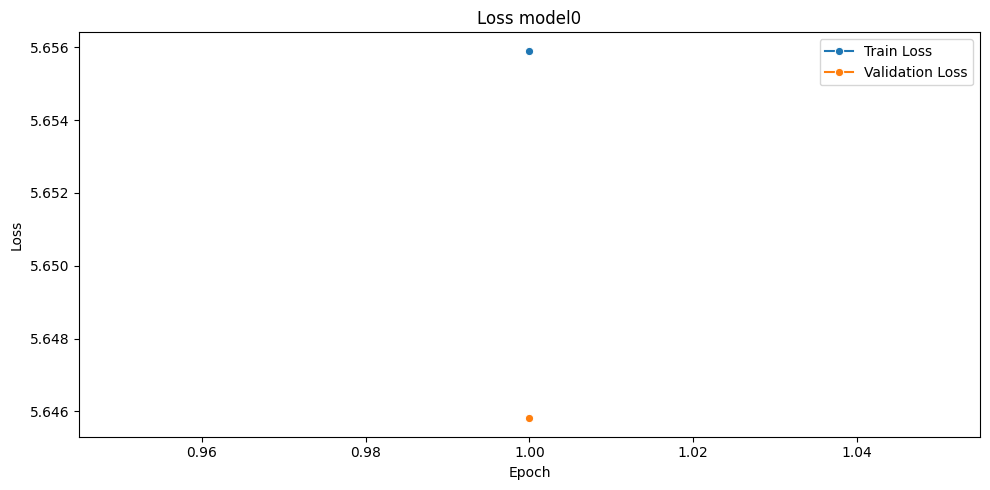

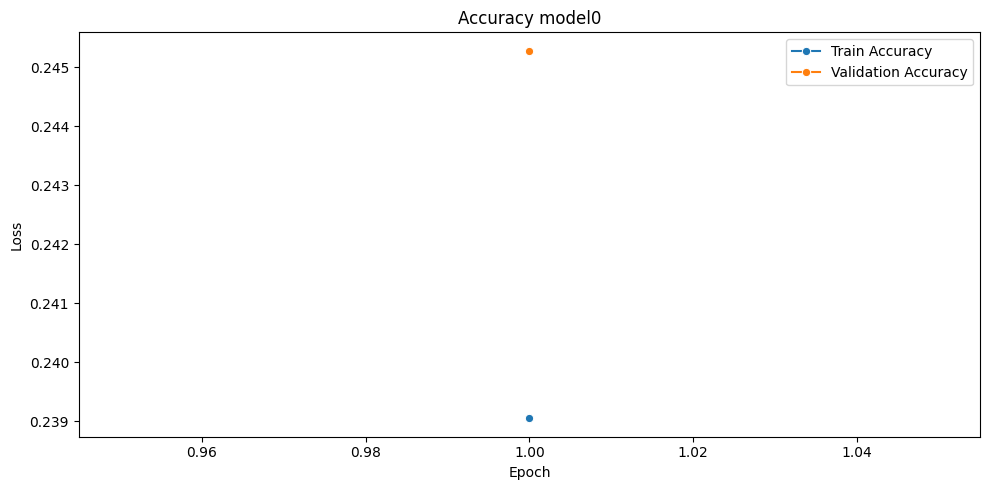

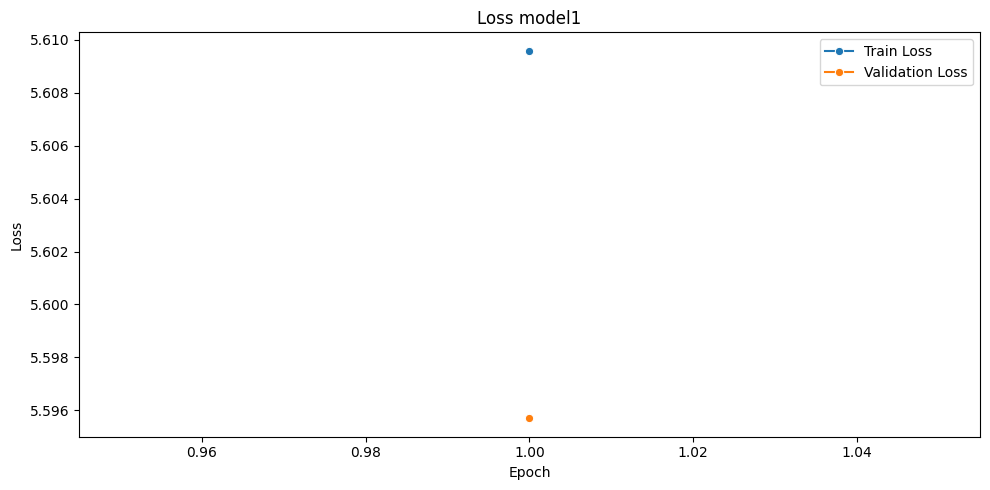

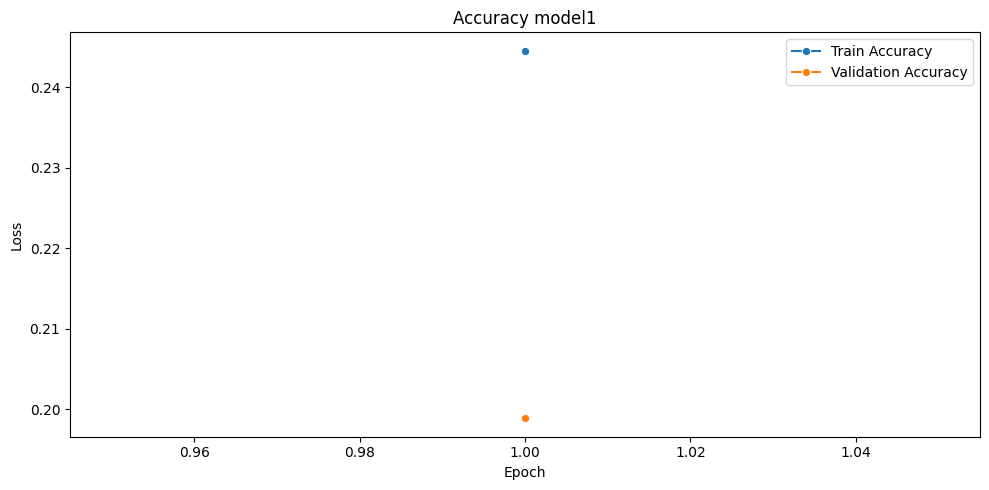

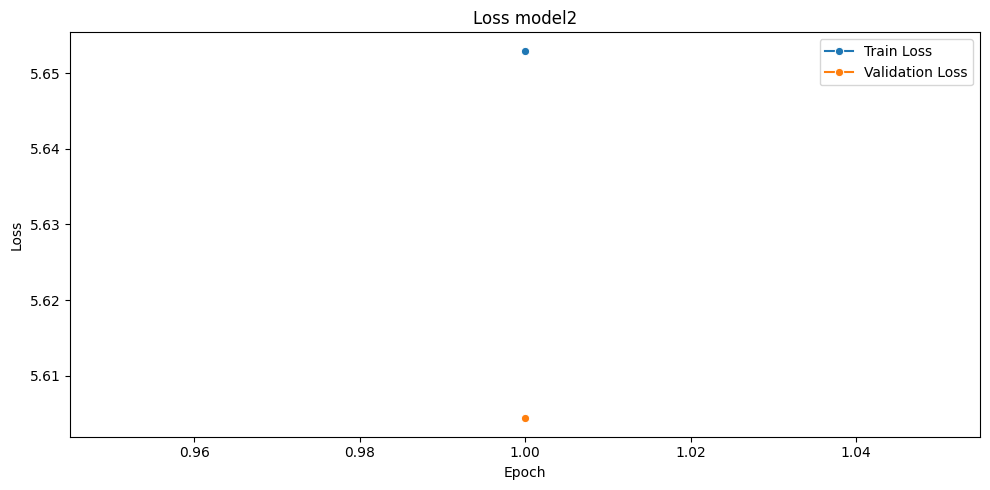

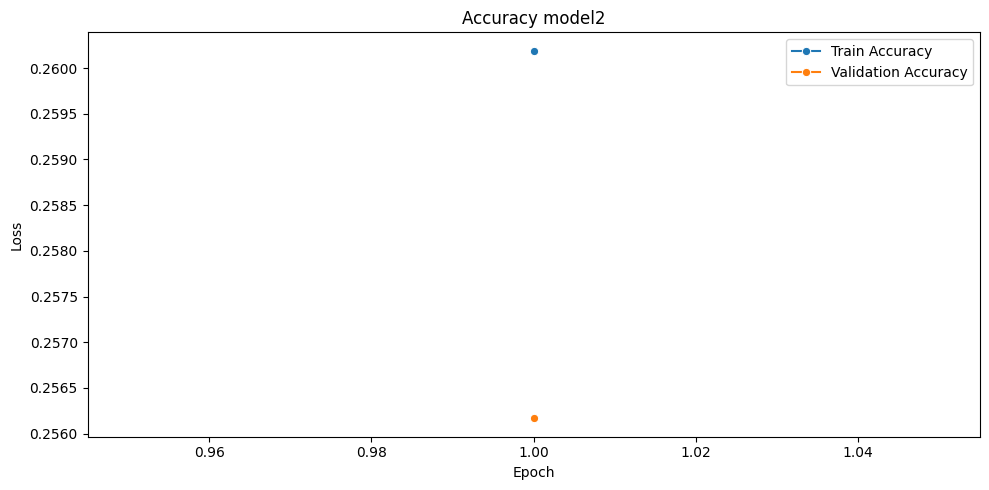

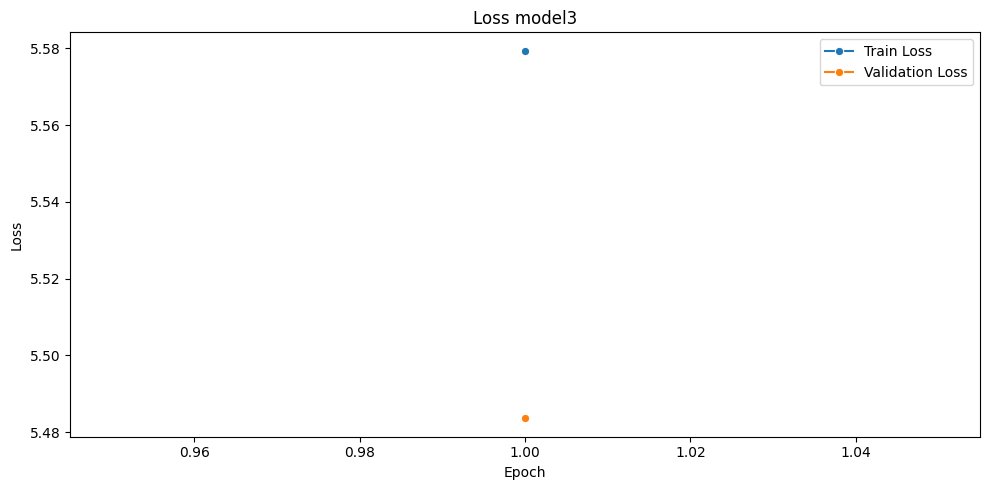

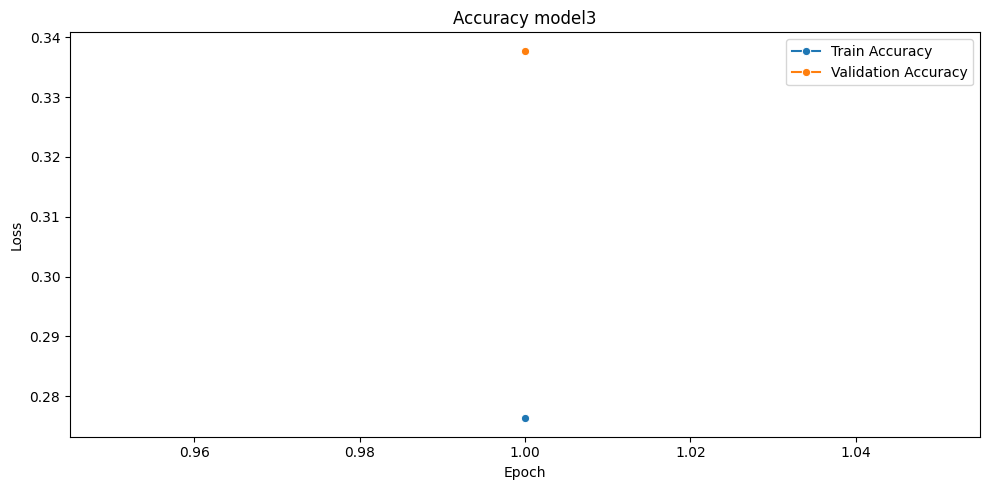

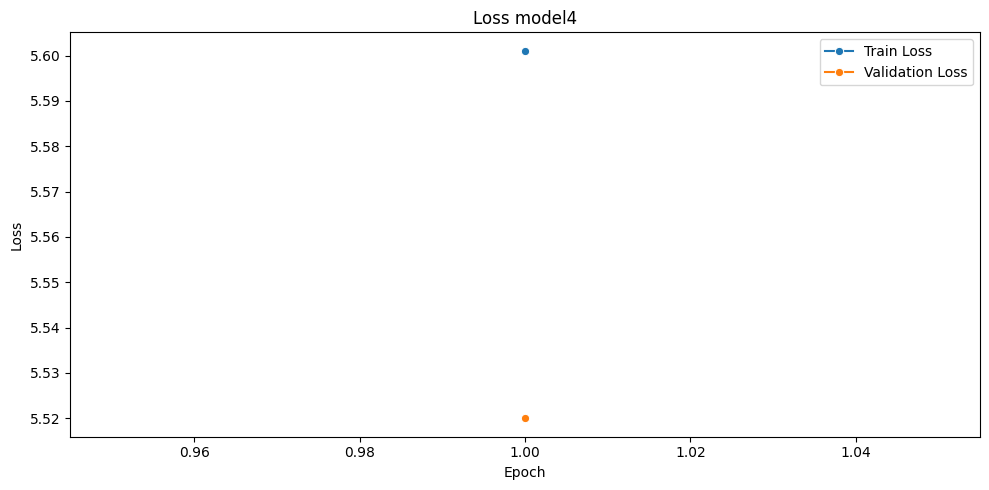

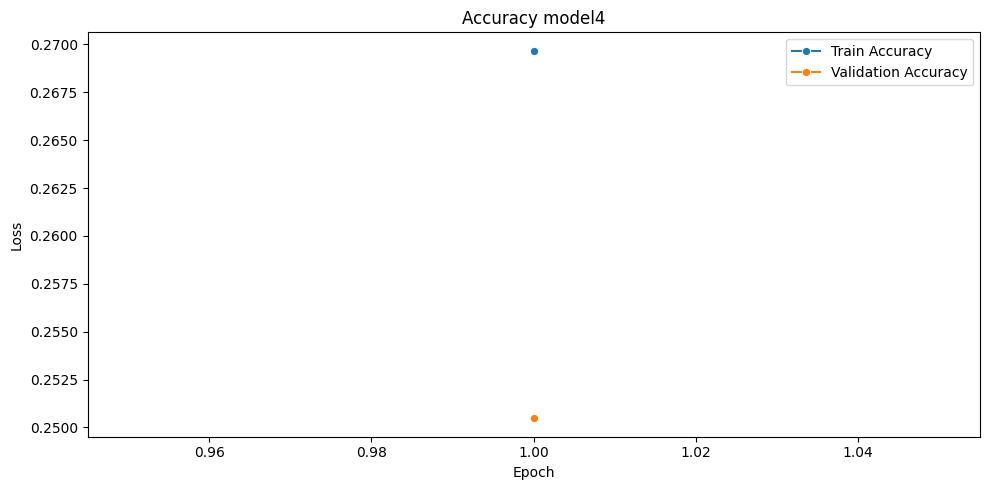

In [17]:
## Task 2
TASKID = 2
K = 5
BALANCED = True
TYPE = "balanced"
training_info, test_info = get_training_testing_data(BALANCED)
training_info, validation_info = split_traing_data(training_info, 0.2)
data_chunks = split_for_cross_validation(training_info, K)

info_test = {"precision": [], "recall": [], "f1Score" : [], "accuracy" : []}
info_validation = {"precision": [], "recall": [], "f1Score" : [], "accuracy" : []}
for i in range(K):
    paths = create_plots_paths(i, TASKID, TYPE)
    data = create_cross_validation_data(data_chunks, test_info, i, compute_train_transformations, compute_test_transformation)
    criterion, optimizer, lr_scheduler = get_parameters(model, torch.tensor(compute_weights(training_info), dtype=torch.float32))
    model = cross_validation_training_one_model(data, paths, i, criterion, optimizer, lr_scheduler)
    precision, recall, f1, acc, mat = test_model(model, data["test"], criterion, BATCH_SIZE)
    save_matrix(mat, paths["matrix"])
    info_test = add_info(info_test, precision, acc, recall, f1)
    precision, recall, f1, acc, mat = test_model(model, data["validation"], criterion, BATCH_SIZE)
    info_validation = add_info(info_validation, precision, acc, recall, f1)
validation_results, test_results = pd.DataFrame.from_dict(info_validation, "columns"), pd.DataFrame.from_dict(info_test, "columns")
print(validation_results)
print(test_results)